In [1]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

from models_mask1_class1_realSENet_before import ResNet as model_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库
from PIL import Image, ImageDraw

print('Init Finished!')

Init Finished!


# Model Load

In [2]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 512
PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/senet/test_256bs_150epoch_layer3_baseline'
# PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/test_256bs_150epoch_layer3_Vgg_mask1'
model_path = os.path.join(PATH, 'saved_model.pt')


In [3]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = model_cifar(depth=20, num_classes=10)
model = model.cuda()
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path))
print('Successfully Load Model: ', os.path.basename(model_path))

Successfully Load Model:  saved_model.pt


In [5]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    str_ = '>'*i + '' ''*(total-k)
    sys.stdout.write('\r'+str_+'[%s%%]'%(i+1))
    sys.stdout.flush()
    if(i >= total -1): print()

In [6]:
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
    # print ('group loss:',group_loss[0])
    y = labels.data
    batch_size = labels.data.shape[0]
    # print(y.resize_(batch_size,1))
    running_corrects += torch.sum(preds == y)
    # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.8708


In [7]:
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
def plot_confusion_matrix_and_text(cm, labels_name, title):
    plt.figure(figsize=(16,16),dpi=200)
    plt.subplot(221)
    plot_confusion_matrix(cm, labels_name, title)
    plt.subplot(222)
    
    text_img = Image.new('RGB', (350, 250), color = (255,255,255))
    d = ImageDraw.Draw(text_img)
    text_content = classification_report(true_labels, model_preds, target_names=labels_name)
    d.text((0,0), text_content, fill=(0,0,0))
    plt.imshow(text_img)
    plt.show()

# Baseline

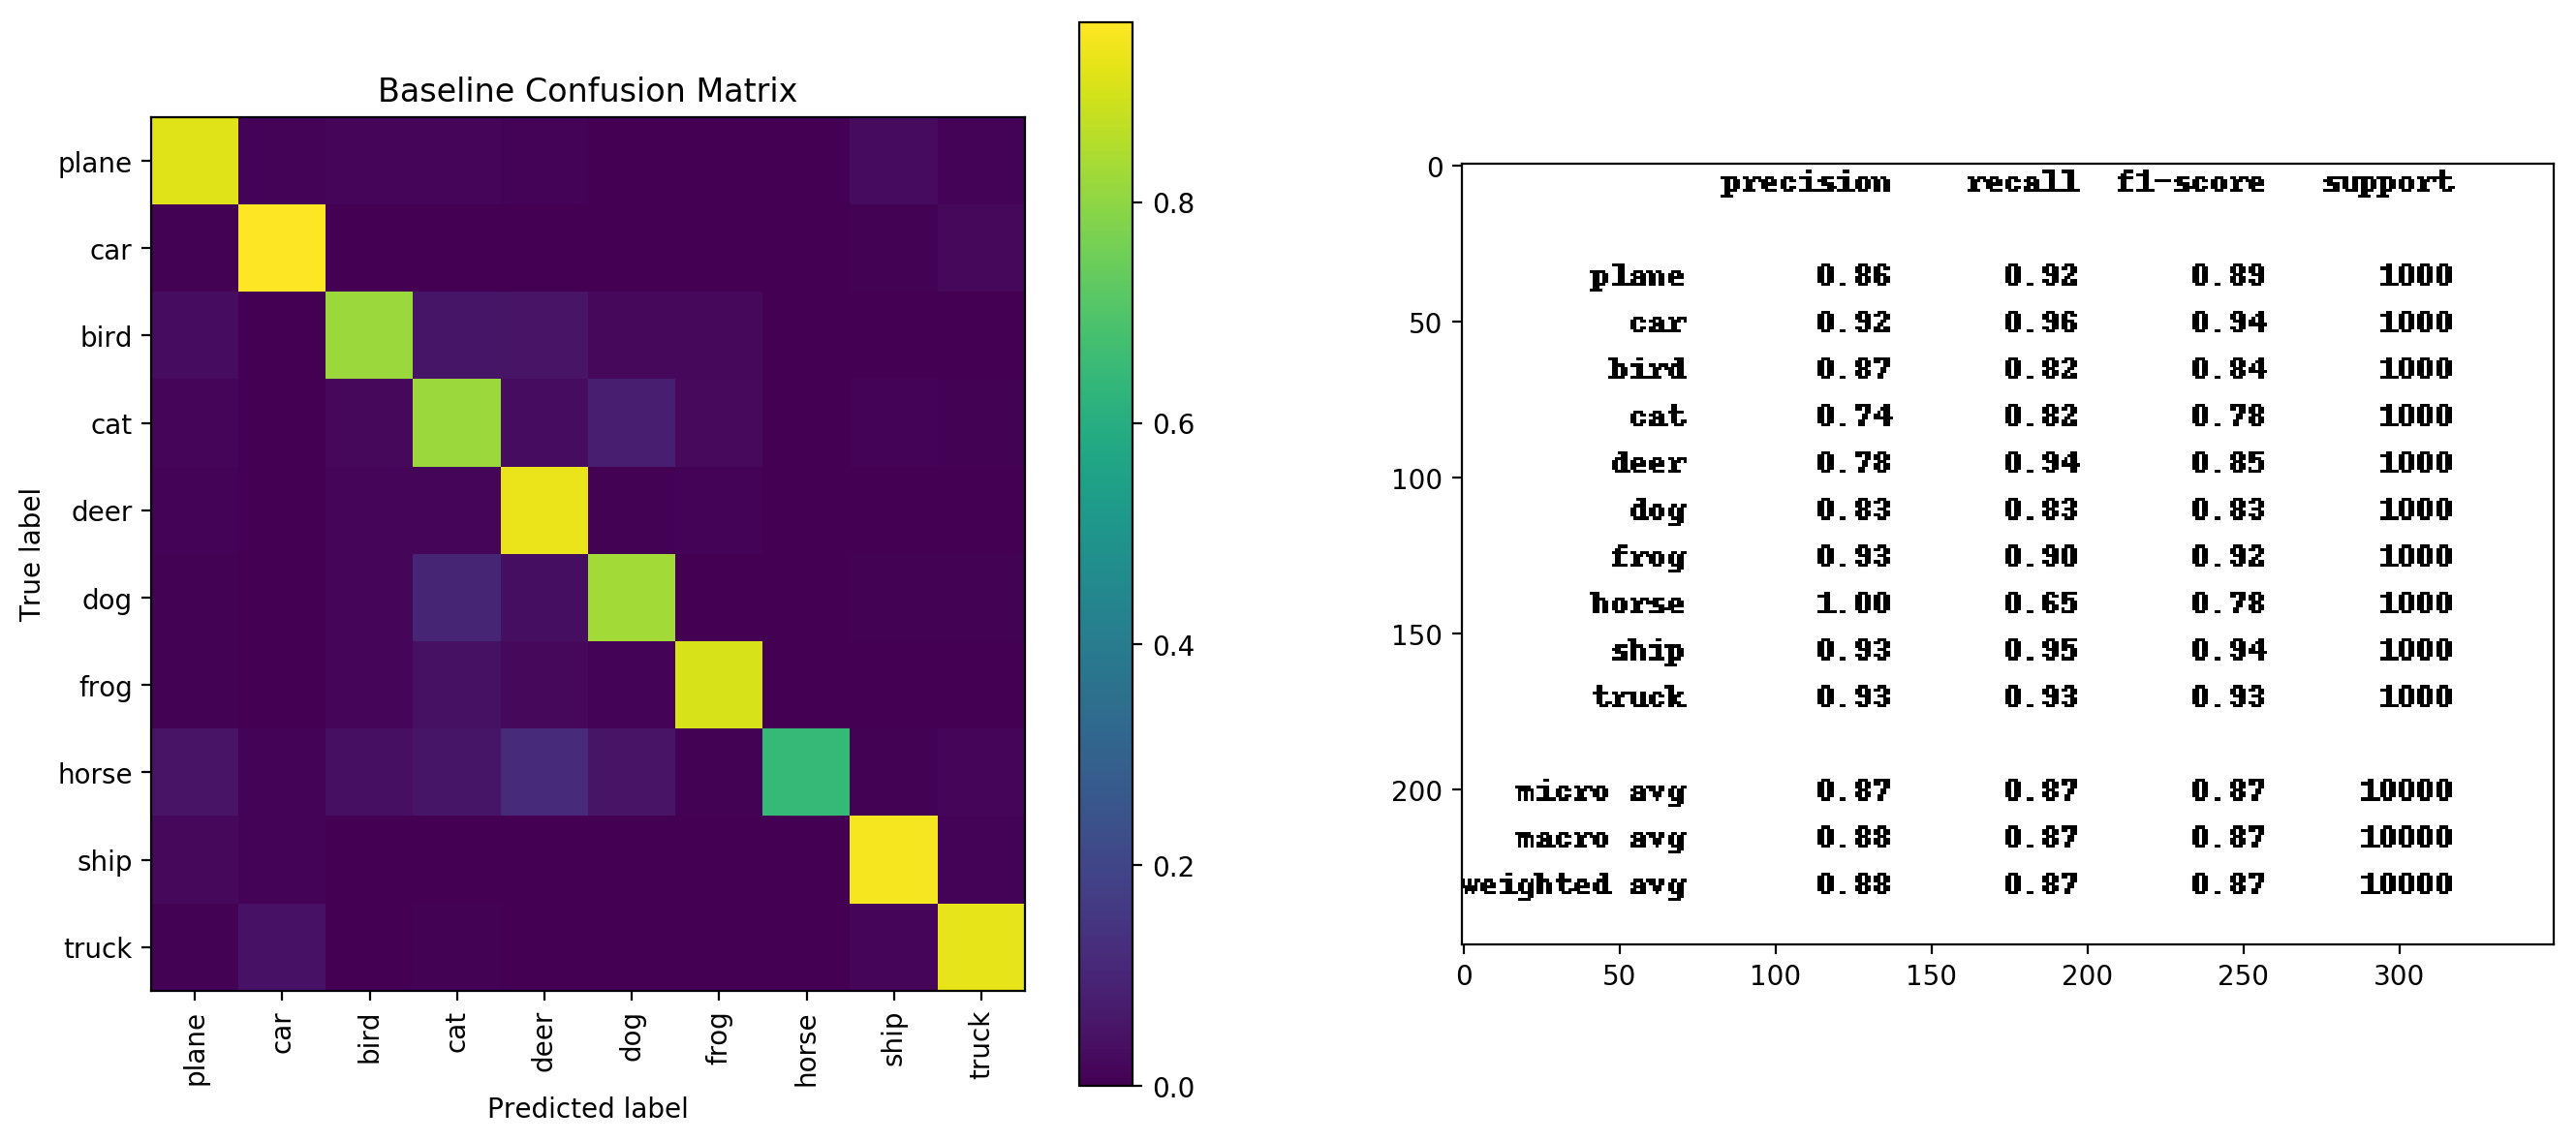

In [8]:
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, "Baseline Confusion Matrix")
# plt.savefig('/HAR_cm.png', format='png')
plt.show()
# print(classification_report(true_labels, model_preds, target_names=labels_name))

# Classification Analysis

In [9]:
table = pd.DataFrame(cm)
table.columns = labels_name
table

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,915,8,14,12,10,1,2,0,28,10
1,7,963,0,3,0,0,1,0,5,21
2,32,2,819,53,50,19,22,0,3,0
3,12,1,20,817,32,80,23,0,11,4
4,9,0,18,17,935,7,9,2,1,2
5,7,3,16,100,34,831,1,0,4,4
6,6,2,13,42,19,10,903,0,3,2
7,51,10,40,55,119,50,6,645,6,18
8,21,11,3,3,1,0,2,0,951,8
9,5,48,0,4,1,0,1,0,12,929


# Mask1 after SElayer

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7911


/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


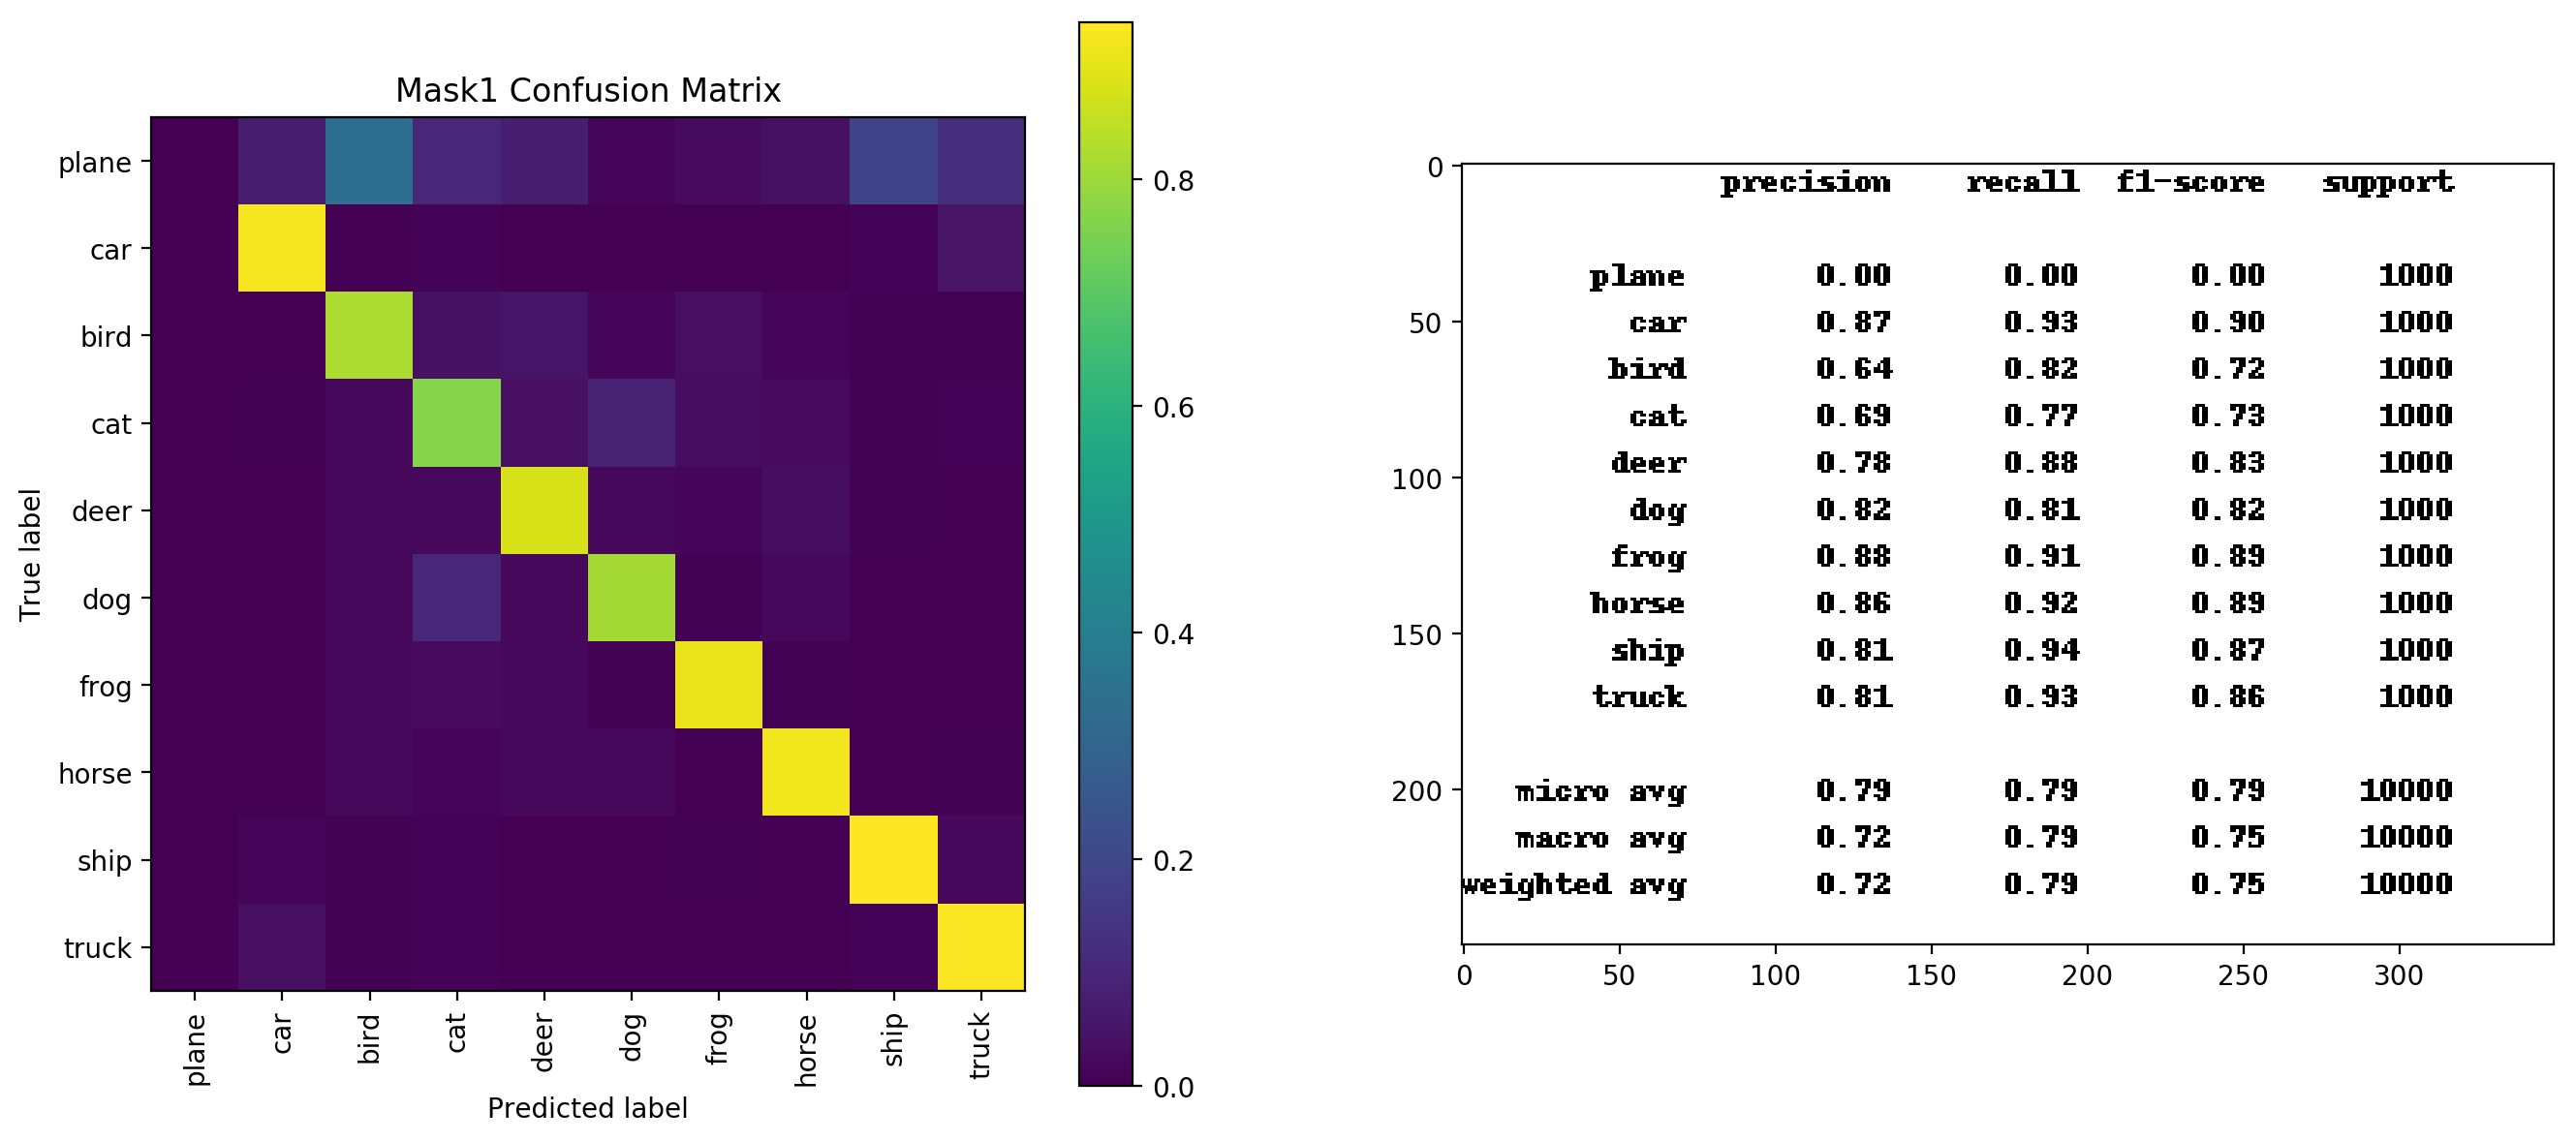

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,0,80,340,104,79,12,29,41,189,126
1,0,925,3,10,2,0,2,1,8,49
2,0,2,825,44,53,17,37,13,5,4
3,0,4,23,769,38,94,30,27,5,10
4,0,0,21,22,881,21,16,34,4,1
5,0,1,21,108,25,813,5,22,3,2
6,0,2,25,26,21,7,909,4,3,3
7,0,0,23,13,21,19,0,918,2,4
8,0,14,4,10,2,1,4,2,939,24
9,0,39,5,9,2,2,0,3,8,932


In [10]:
PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/senet/test_256bs_150epoch_layer3_MaskafterSenet'
model_path = os.path.join(PATH, 'saved_model.pt')
model.load_state_dict(torch.load(model_path))
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
    # print ('group loss:',group_loss[0])
    y = labels.data
    batch_size = labels.data.shape[0]
    # print(y.resize_(batch_size,1))
    running_corrects += torch.sum(preds == y)
    # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, "Mask1 Confusion Matrix")
plt.show() 
# print(classification_report(true_labels, model_preds, target_names=labels_name))
table = pd.DataFrame(cm)
table.columns = labels_name
table

# Mask 1 before SELayer

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.7822


/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


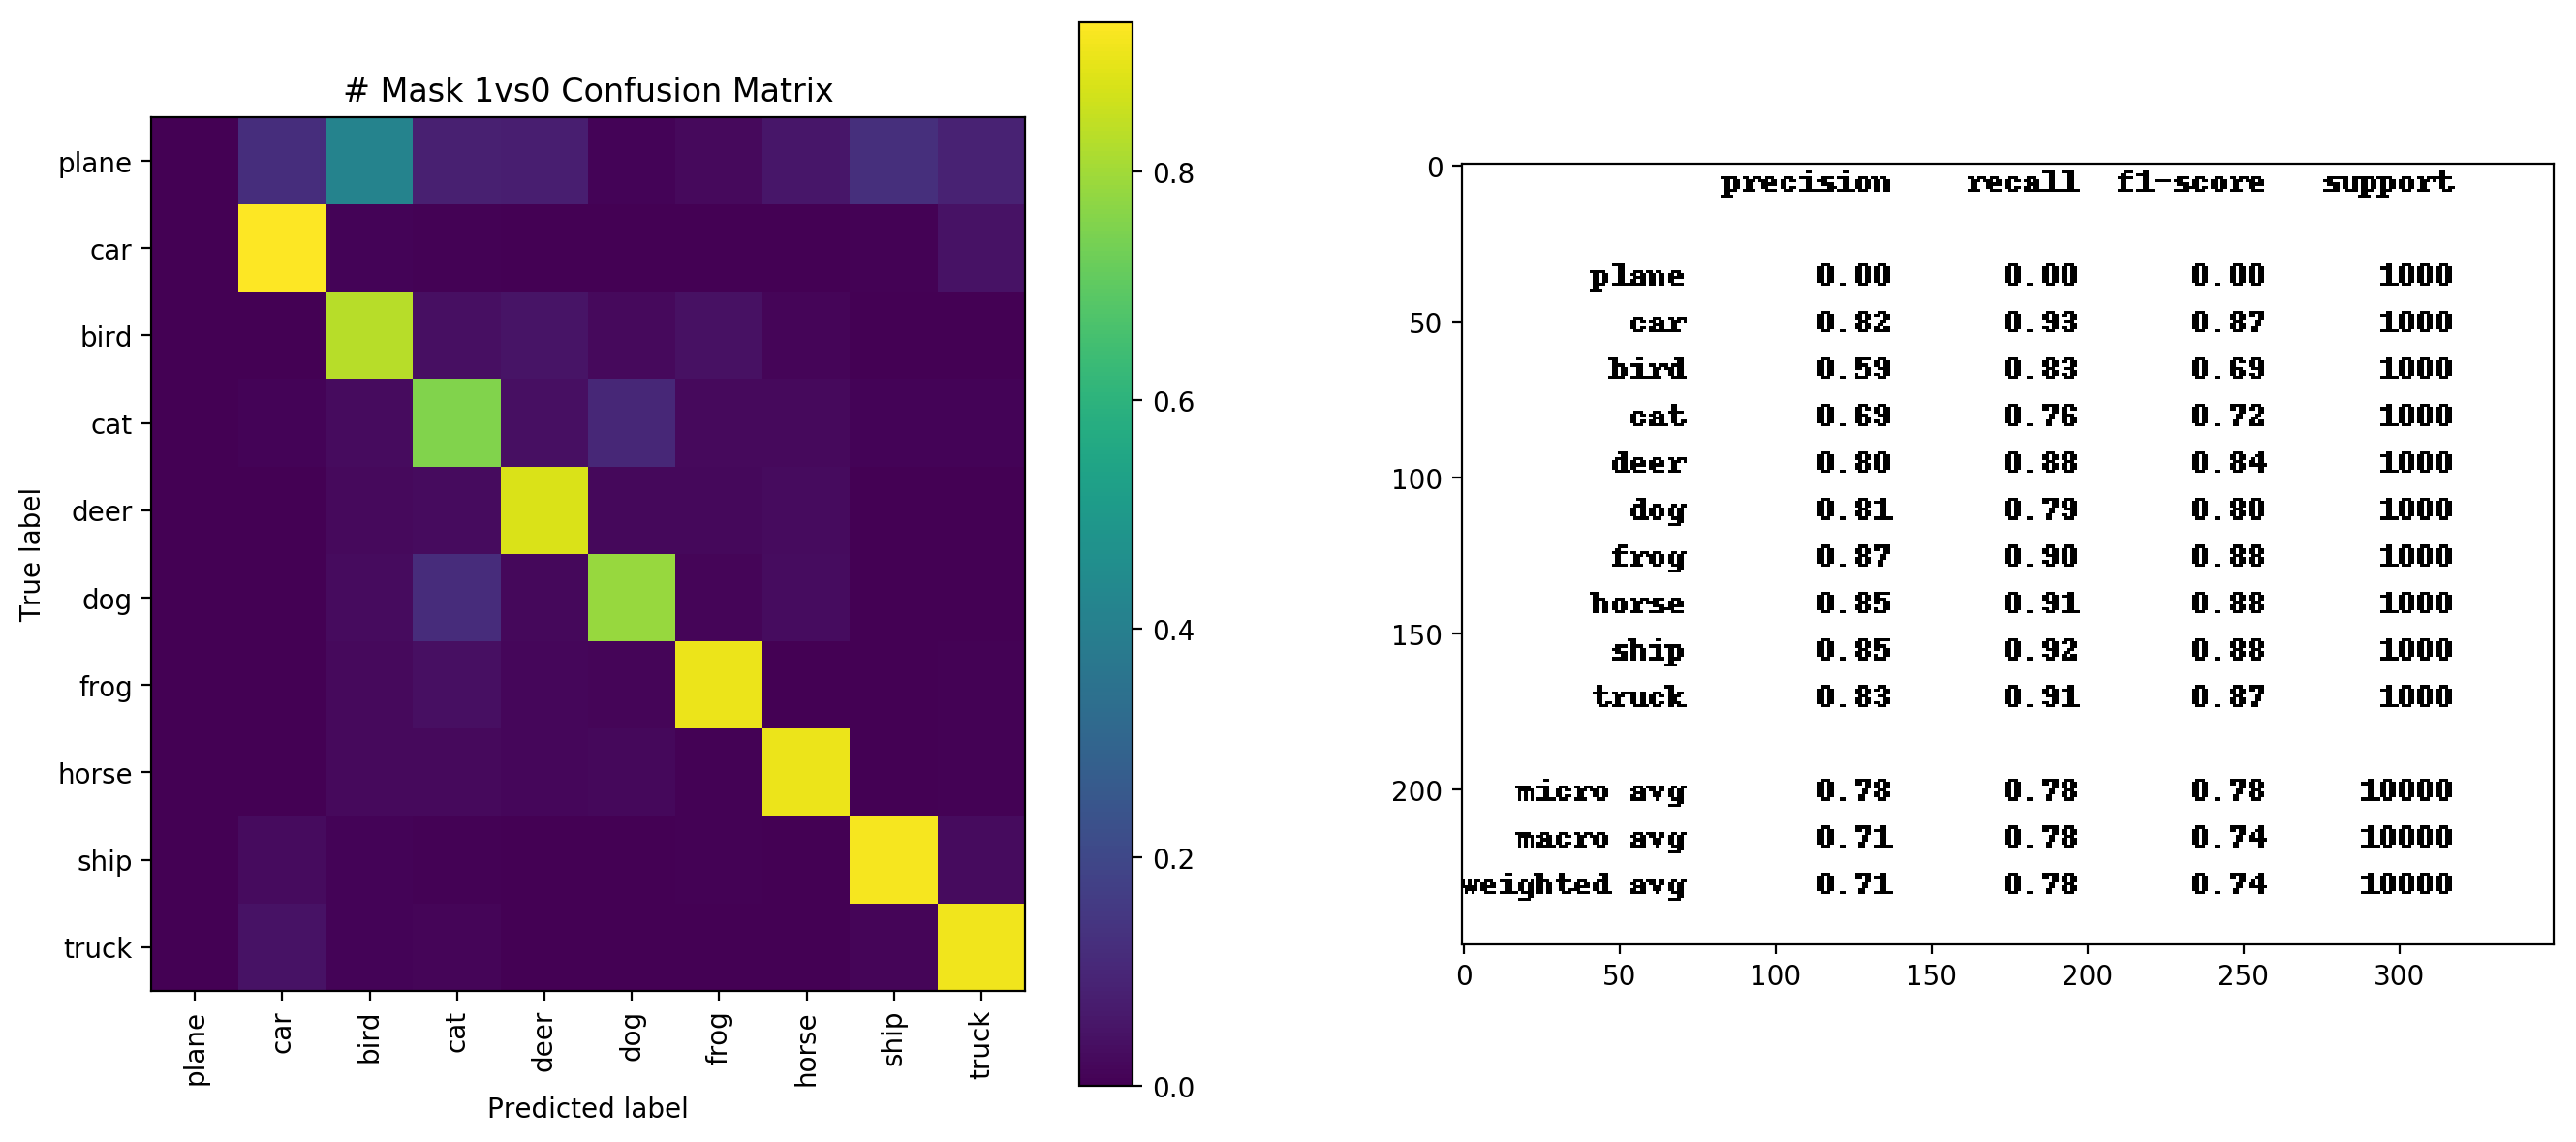

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,0,121,417,81,78,9,22,56,126,90
1,0,931,9,4,2,1,2,3,4,44
2,0,1,832,37,48,22,41,13,3,3
3,0,8,29,755,40,104,25,22,8,9
4,0,1,25,27,878,19,20,27,2,1
5,0,1,27,120,20,789,11,32,0,0
6,0,1,22,37,16,12,903,3,1,5
7,0,2,23,22,15,20,7,905,1,5
8,0,26,10,6,2,1,7,2,917,29
9,0,47,9,11,2,1,3,2,13,912


In [11]:
PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/senet/test_256bs_150epoch_layer3_MaskbeforeSenet'
model_path = os.path.join(PATH, 'saved_model.pt')
model.load_state_dict(torch.load(model_path))
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
    # print ('group loss:',group_loss[0])
    y = labels.data
    batch_size = labels.data.shape[0]
    # print(y.resize_(batch_size,1))
    running_corrects += torch.sum(preds == y)
    # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, "# Mask 1vs0 Confusion Matrix")
plt.show() 
# print(classification_report(true_labels, model_preds, target_names=labels_name))
table = pd.DataFrame(cm)
table.columns = labels_name
table

# test_256bs_150epoch_layer3_RealBeforeSEMask

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[97%]val top1 Acc:0.8006


/home/ouyangzhihao/anaconda3/envs/OYZH/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


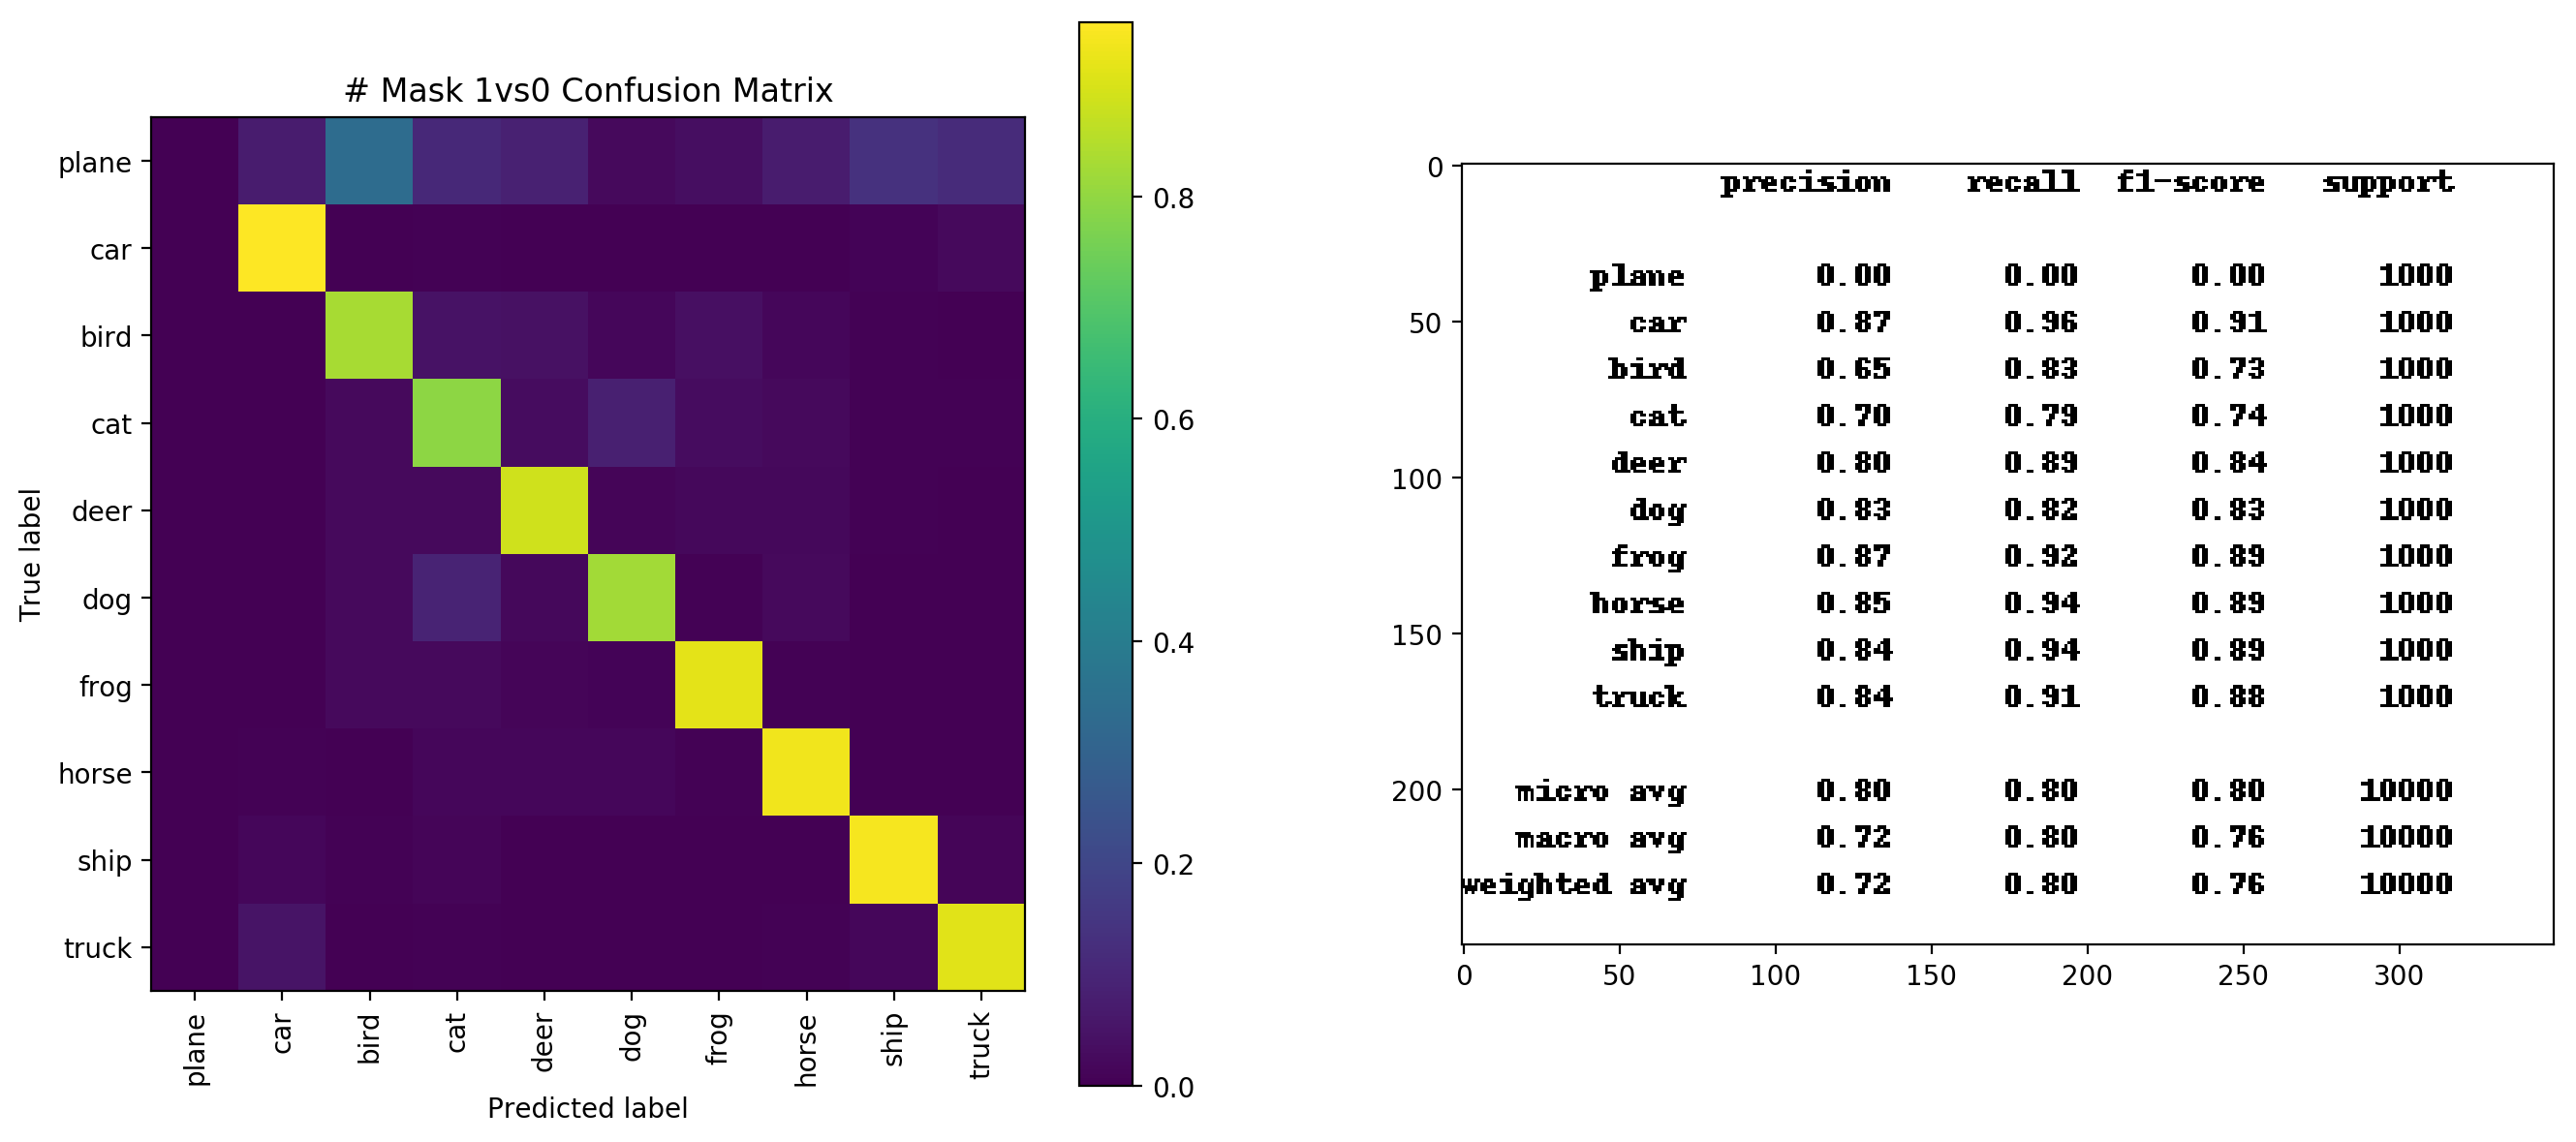

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,0,74,338,110,88,26,37,73,135,119
1,0,957,2,7,0,0,0,0,10,24
2,0,1,831,47,42,18,38,17,5,1
3,0,3,24,793,33,83,31,23,4,6
4,0,0,25,24,888,14,20,22,4,3
5,0,1,24,97,22,824,5,24,2,1
6,0,2,25,25,14,10,919,4,1,0
7,0,4,3,16,16,17,5,936,1,2
8,0,15,7,13,3,2,2,2,944,12
9,0,49,3,7,2,1,2,6,16,914


In [12]:
PATH = '/data/ouyangzhihao/Exp/ICNN/Resnet_ICNN/tb_dir/cifar_exp/senet/test_256bs_150epoch_layer3_RealBeforeSEMask'
model_path = os.path.join(PATH, 'saved_model.pt')
model.load_state_dict(torch.load(model_path))
use_gpu = True
epoch = 1
phase = 'val'
running_corrects = 0.0
data_len = len(dataloaders[phase])
# print(data_len)
true_labels = []
model_preds = []
for idx,data in enumerate(dataloaders[phase]):
    printF(idx, data_len)
    inputs,labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    #forward
    outputs = model(inputs, labels, epoch)
    _, preds = torch.max(outputs.data, 1)
    # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
    # print ('group loss:',group_loss[0])
    y = labels.data
    batch_size = labels.data.shape[0]
    # print(y.resize_(batch_size,1))
    running_corrects += torch.sum(preds == y)
    # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
    epoch_acc = float(running_corrects) /dataset_sizes[phase]
    true_labels.extend(y.cpu().numpy())
    model_preds.extend(preds.cpu().numpy())
print('%s top1 Acc:%.4f'%(phase,epoch_acc))
cm = confusion_matrix(y_true=true_labels, y_pred=model_preds)
plot_confusion_matrix_and_text(cm, labels_name, "# Mask 1vs0 Confusion Matrix")
plt.show() 
# print(classification_report(true_labels, model_preds, target_names=labels_name))
table = pd.DataFrame(cm)
table.columns = labels_name
table